In [1]:
from collections import defaultdict
import re
from tqdm.notebook import tqdm
import math
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
# read data files
ted_texts = []
with open('ted.txt', 'r') as fp:
    for line in fp:
        ted_texts.append(line)
        
reddit_texts = []
with open('reddit.txt', 'r') as fp:
    for line in fp:
        reddit_texts.append(line)
        
test_news = []
with open('test.news.txt', 'r') as fp:
    for line in fp:
        test_news.append(line)

test_reddit = []
with open('test.reddit.txt', 'r') as fp:
    for line in fp:
        test_reddit.append(line)

test_ted = []
with open('test.ted.txt', 'r') as fp:
    for line in fp:
        test_ted.append(line)

In [3]:
class Preprocesser(object):
    def __init__(self,ms = True):
        self.ms = ms
    
    def apply(self, text):
        # text to lower case
        text = text.lower()
        # merge multiple spaces to single space
        if self.ms:
            text = re.sub(r'\s+', ' ', text) 
        # tokenize text
        doc = text.split()
        tokens = [token for token in doc]
        return tokens
    
preprocesser = Preprocesser()


In [4]:
class NGram(object):
    
    def __init__(self,n=1):
        # ngram number
        self.n_num = n
        self.history = defaultdict(lambda: 0) # dictionary with counts of n-1 grams
        self.ngram_count = defaultdict(lambda: 0) # dictionary with counts of n grams
        self.vocab = {} # vocabulary
        self.total_count = 0 # total count of all words
        self.uni_prob = False # boolean to toggle uniform probability
        self.laplace_smoothing = False # boolean to toggle laplace smoothing
      
    def fit(self, texts):
        ''' fits data to model'''
        if not self.n_num == 1:
            self._history_count(texts)
        self._ngram_count(texts)

    def _history_count(self, texts):
        ''' this function counts frequencies for n-1 grams in the training data
            input: list of texts
        '''
        for text in texts:
            # tokenize text
            tokens = preprocesser.apply(text)
            # pad tokens with start of sentence token
            for _ in range(self.n_num-1):
                tokens.insert(0,'<s>')
            # loop through text tokens to store n-1 grams with count in history
            for i,tok in enumerate(tokens):
                if i<len(tokens)-self.n_num+2:
                    w = ''
                    # convert n-1 gram tokens to history string
                    for k in range(self.n_num-1):
                        w = w + ' ' + tokens[i+k]
                    self.history[w.strip()]+=1
    
    def _ngram_count(self, texts):
        ''' this function counts frequencies for n grams in the training data
            input: list of texts
        '''
        for text in texts:
            # tokenize text
            tokens = preprocesser.apply(text)
            # pad tokens with start of sentence token
            for _ in range(self.n_num-1):
                tokens.insert(0,'<s>')
            # loop through text tokens to store n grams with count in history
            for i,tok in enumerate(tokens):
                if i<len(tokens)-self.n_num+1:
                    w = ''
                    # convert ngram tokens to ngram string
                    for k in range(self.n_num):
                        w = w + ' ' + tokens[i+k]
                    self.ngram_count[w.strip()]+=1
                self.vocab[tok]=1
        
        # calculate total count of all frequencies
        if self.n_num == 1:
            self.total_count = sum(list(self.ngram_count.values()))
        else:
            self.total_count = sum(list(self.vocab.values())[1:])
        
    def probability(self, ngrams):
        ''' This funciton calculates the probability of ngram
            input : ngram tokens
            output : probability
        '''
        prob = 0.
        # probability for n = 1
        if self.n_num==1 and self.laplace_smoothing==False:
            if self.uni_prob == False:
                # relative frequencies
                prob = self.ngram_count[ngrams[0]]/self.total_count
                # if word is out of vocabulary assign lowest probability
                if prob==0:
                    prob=1/self.total_count
            else:
                # uniform probability
                prob = 1/self.total_count
            return prob

        # probability with laplace smoothing for n = 1
        if self.n_num==1 and self.laplace_smoothing==True:
            prob = (self.ngram_count[ngrams[0]]+1)/(self.total_count+len(self.vocab))
            return prob
        
        # convert tokens to ngram strings
        ngram = ''
        hist = ''
        for i,word in enumerate(ngrams):
            ngram += ' ' + word
            if i<len(ngrams)-1:
                hist += ' ' + word
        
        if not(self.n_num==1):
            # probability without laplace smoothing
            if self.laplace_smoothing==False:
                if self.history[hist.strip()]==0 or self.ngram_count[ngram.strip()]==0:
                    # skip if ngram or history dont exist
                    return 1
                else:
                    # pr = count(Wn)/Count(Wn-1)
                    prob = self.ngram_count[ngram.strip()]/self.history[hist.strip()]
            else:
            # probability with laplace smoothing
                if self.history[hist.strip()]==0:
                    return 1
                else:
                    # laplace smoothed prob = count(wn)+1 / count(wn-1) + V where V is vocab size
                    prob = (self.ngram_count[ngram.strip()]+1)/(self.history[hist.strip()]+(len(self.vocab)))
        return prob

    def perplexity(self, texts):
        ''' This function calculates average perplexity of all input sentences
            input : list of sentences
        '''

        sent_perp_list =[] # stores perplexity of a sentence
        for text in texts:
            perp = 1.
            len_sentence = 0
            logsum=0
            # tokenize text
            tokens = preprocesser.apply(text)
            # if empty text skip
            if len(tokens)==0:
                continue
            len_sentence = len(tokens)
            # pad tokens
            for _ in range(self.n_num-1):
                tokens.insert(0,'<s>')
            i=0
            # calculate probability of each n-gram sequence in sentence
            while i < (len(tokens) - self.n_num + 1):
                p = self.probability(tokens[i:i+self.n_num])
                logsum += math.log(p)
                i+=1
            # calculate perplexity
            perp = math.exp((-1/len_sentence)*logsum)
            # add to list of perplexities
            sent_perp_list.append(perp)
        # average perplexity of all sentences
        avg_perp = sum(sent_perp_list)/len(sent_perp_list)

        return avg_perp
    
    
    def predict(self, w):
        ''' this function gives next word given an input sequence of n-1 grams
        '''
        w_next = None # next word
        max_p = 0
            
        # loop through each word in vocab
        for word in list(self.vocab.keys())[1:]:
            his = w.copy()
            # append candidate word to history
            his.append(word)
            # calculate n-gram probabilty
            p = self.probability(his)
            # check if prob is max, assign candidate as next word
            if p>max_p and not p==1:
                max_p=p
                w_next=word
        # if no word predicted assign full stop as next word
        if w_next==None:
            w_next = '.'

        return w_next

### Part 1

In [5]:
# one gram language model using uniform probabilty
one_gram = NGram(1)
one_gram.uni_prob=True
one_gram.fit(ted_texts)
# perplexity scores
onegram_perp_red = one_gram.perplexity(test_reddit)
onegram_perp_ted = one_gram.perplexity(test_ted)
onegram_perp_news = one_gram.perplexity(test_news)

print(f'The perplexity of OneGram with Uniform Probability on reddit test is: {onegram_perp_red:.4f}')
print(f'The perplexity of OneGram with Uniform Probability on ted test is: {onegram_perp_ted:.4f}')
print(f'The perplexity of OneGram with Uniform Probability on news test is: {onegram_perp_news:.4f}')


The perplexity of OneGram with Uniform Probability on reddit test is: 4751625.0000
The perplexity of OneGram with Uniform Probability on ted test is: 4751625.0000
The perplexity of OneGram with Uniform Probability on news test is: 4751625.0000


### Part 2

In [6]:

# switch to relative frequencies as probability
one_gram.uni_prob=False
# perplexity scores
onegram_perp_red = one_gram.perplexity(test_reddit)
onegram_perp_ted = one_gram.perplexity(test_ted)
onegram_perp_news = one_gram.perplexity(test_news)

print(f'The perplexity of OneGram with relative Probability on reddit test is: {onegram_perp_red:.4f}')
print(f'The perplexity of OneGram with relative Probability on ted test is: {onegram_perp_ted:.4f}')
print(f'The perplexity of OneGram with relative Probability on news test is: {onegram_perp_news:.4f}')


The perplexity of OneGram with relative Probability on reddit test is: 7857.2820
The perplexity of OneGram with relative Probability on ted test is: 868.7476
The perplexity of OneGram with relative Probability on news test is: 9329.2428


### Part 3

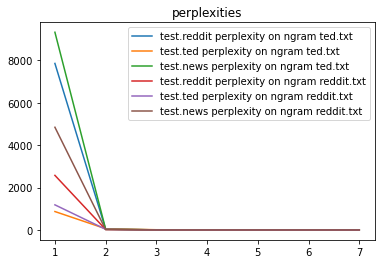

In [7]:
# generate ngram models from n = 1 to 7  without laplace smoothing and calculate perplexities
perp_list_ted = []
perp_list_reddit = []
for n in range(7):
    perp_ted = []
    perp_reddit = []
    ngram_ted = NGram(n+1)
    # fit data
    ngram_ted.fit(ted_texts)
    ngram_reddit = NGram(n+1)
    # fit data
    ngram_reddit.fit(reddit_texts)
    perp_ted.append(ngram_ted.perplexity(test_reddit))
    perp_ted.append(ngram_ted.perplexity(test_ted))
    perp_ted.append(ngram_ted.perplexity(test_news))
    perp_list_ted.append(perp_ted)
    perp_reddit.append(ngram_reddit.perplexity(test_reddit))
    perp_reddit.append(ngram_reddit.perplexity(test_ted))
    perp_reddit.append(ngram_reddit.perplexity(test_news))
    perp_list_reddit.append(perp_reddit)

pr = np.array(perp_list_reddit)
pt = np.array(perp_list_ted)
plt.plot(np.arange(1,8).T,pt.T[0],label='test.reddit perplexity on ngram ted.txt')
plt.plot(np.arange(1,8).T,pt.T[1],label='test.ted perplexity on ngram ted.txt')
plt.plot(np.arange(1,8).T,pt.T[2],label='test.news perplexity on ngram ted.txt')

plt.plot(np.arange(1,8).T,pr.T[0],label='test.reddit perplexity on ngram reddit.txt')
plt.plot(np.arange(1,8).T,pr.T[1],label='test.ted perplexity on ngram reddit.txt')
plt.plot(np.arange(1,8).T,pr.T[2],label='test.news perplexity on ngram reddit.txt')

plt.legend()
plt.title('perplexities')
plt.show()
    
    

### Part 4

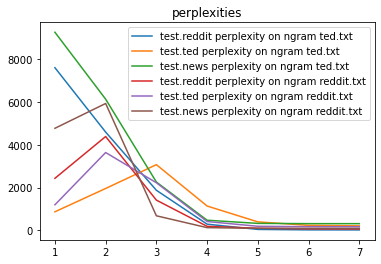

In [8]:
# generate ngram models from n = 1 to 7  with laplace smoothing and calculate perplexities
perp_list_ted = []
perp_list_reddit = []
for n in range(7):
    perp_ted = []
    perp_reddit = []
    ngram_ted = NGram(n+1)
    ngram_ted.laplace_smoothing=True
    ngram_ted.fit(ted_texts)
    ngram_reddit = NGram(n+1)
    ngram_reddit.laplace_smoothing=True
    ngram_reddit.fit(reddit_texts)
    perp_ted.append(ngram_ted.perplexity(test_reddit))
    perp_ted.append(ngram_ted.perplexity(test_ted))
    perp_ted.append(ngram_ted.perplexity(test_news))
    perp_list_ted.append(perp_ted)
    perp_reddit.append(ngram_reddit.perplexity(test_reddit))
    perp_reddit.append(ngram_reddit.perplexity(test_ted))
    perp_reddit.append(ngram_reddit.perplexity(test_news))
    perp_list_reddit.append(perp_reddit)

pr = np.array(perp_list_reddit)
pt = np.array(perp_list_ted)
plt.plot(np.arange(1,8).T,pt.T[0],label='test.reddit perplexity on ngram ted.txt')
plt.plot(np.arange(1,8).T,pt.T[1],label='test.ted perplexity on ngram ted.txt')
plt.plot(np.arange(1,8).T,pt.T[2],label='test.news perplexity on ngram ted.txt')

plt.plot(np.arange(1,8).T,pr.T[0],label='test.reddit perplexity on ngram reddit.txt')
plt.plot(np.arange(1,8).T,pr.T[1],label='test.ted perplexity on ngram reddit.txt')
plt.plot(np.arange(1,8).T,pr.T[2],label='test.news perplexity on ngram reddit.txt')

plt.legend()
plt.title('perplexities')
plt.show()
    
    

In [9]:
# least in-domain perp for ted.txt is at n = 5

# least in-domain perp for reddit.txt is at n = 4

### Part 5

In [10]:
# 5gram model for ted.txt
tedgram = NGram(5)
tedgram.fit(ted_texts)
tedgram.laplace_smoothing=True
# first input sequence
teds = ['<s>']*4

# 4gram model for reddit.txt
redgram = NGram(4)
redgram.fit(reddit_texts)
redgram.laplace_smoothing=True
# first input sequence
reds = ['<s>']*3

teddoc = ''
reddoc = ''
for i in tqdm(range(500)):
    # predict next word
    tednext = tedgram.predict(teds)
    rednext = redgram.predict(reds)
    # add next word and remove previous first word
    teds.pop(0)
    teds.append(tednext)

    reds.pop(0)
    reds.append(rednext)

    # generate doc
    teddoc = teddoc + tednext + ' '
    reddoc = reddoc + rednext + ' '

    # if end of sentence is predicted begin new sequence
    if tednext == '.' :
        strteds = tednext
        while not strteds.split()[0]=='<s>':
            strteds = random.choice(list(tedgram.history.keys()))
        teds = strteds.split()

    if rednext == '.' :
        strreds = rednext
        while not strreds.split()[0] == '<s>':
            strreds = random.choice(list(redgram.history.keys()))
        reds = strreds.split()

print(teddoc)

    

  0%|          | 0/500 [00:00<?, ?it/s]

and i think that 's a really important thing . that should be making a major contribution are instead seen as part of the work , the quality of the work , the quality of the work , the quality of the work , the quality of the work , the quality of the work , the quality of the work , the quality of the work , the quality of the work , the quality of the work , the quality of the work , the quality of the work , the quality of the work , the quality of the work , the quality of the work , the quality of the work , the quality of the work , the quality of the work , the quality of the work , the quality of the work , the quality of the work , the quality of the work , the quality of the work , the quality of the work , the quality of the work , the quality of the work , the quality of the work , the quality of the work , the quality of the work , the quality of the work , the quality of the work , the quality of the work , the quality of the work , the quality of the work , the quality o

In [11]:
print(reddoc)

i ’ m not sure what to tell you that . back from ossi for summer 2018 or in past ? < . thursday 03/29/18 i have my baby tok . it may , there * is * a cluster b personality disorders . are in your top 4 ? < . figured it could be asserting his marital rights . message about future games wtf did you start calling your partners parents your in laws ? < . ( 45 ) watched male entertainers / strip show and i ’ m not sure what to tell you that . yeah we used to but very few pots . - 27 march 2018 - no question too small ! 1 ) delete the alexa skill and any redundant smart devices located in your smart section . supporters burst into tears as they are in the box ! < . brain of a /pol/yp yeah . . extended to april 10th ! < . remember , and please fact check me on this . banned for cheating ? < . of the day - * subgenre : new weird - fifth row across : * any r/fantasy goodreads group book of the month - * format : graphic novel ( at least one volume ) or audiobook - sandman neil gaiman * novel fe

In [12]:
print('Perplexity for ted.out : ' , tedgram.perplexity(teddoc))
print('Perplexity for reddit.out : ' , redgram.perplexity(reddoc))

Perplexity for ted.out :  145095.2876676645
Perplexity for reddit.out :  35586.63555848302


In [13]:
import codecs
tedout = codecs.open('ted.out','w',encoding='utf-8')
tedout.write(teddoc)
tedout.close()

redout = codecs.open('red.out','w',encoding='utf-8')
redout.write(teddoc)
redout.close()